In [5]:
import numpy as np
from define_stress_and_stretch import von_mises, vonH
from get_turnover_class import *
from read_tav_xplt import StateTimes, nDoms

'''
This script takes an array of the modulus of elements at the end of the past iteration and uses the stress 
perturbation to calculate the new modulus at the end of the next day. 
'''


'\nThis script takes an array of the modulus of elements at the end of the past iteration and uses the stress \nperturbation to calculate the new modulus at the end of the next day. \n'

In [77]:
# initialising parameters: 
# Original mass values 
mC0 = 62
mE0 = 38
m_total = mC0 + mE0
frac_C0 = 0.62
frac_E0 = 0.38

In [88]:
counter = np.loadtxt("saved_data/counter.txt", delimiter = ',')
print(counter[1]) 

if counter[1] == 0.0:
    mC0_array = []
    for x in range(0,1064):
        x = mC0
        mC0_array.append(x)
    mE0_array = []
    for x in range(0,1064):
        x = mE0
        mE0_array.append(x)
    m0_array = []
    for x in range(0, 1064): 
        x = m_total
        m0_array.append(x)
    frac_C_array = []
    for x in range(0, 1064): 
        x = frac_C0
        frac_C_array.append(x)
    frac_E_array = []
    for x in range(0, 1064): 
        x = frac_E0
        frac_E_array.append(x)
    th0 = np.loadtxt("saved_data/original_thickness_storage.txt", delimiter = ',')
    thS = th0
    np.savetxt("saved_data/current_collagen_mass_storage.txt", mC0_array, delimiter =',')
    np.savetxt("saved_data/current_elastin_mass_storage.txt", mE0_array, delimiter =',')
    np.savetxt("saved_data/current_overall_mass_storage.txt", m0_array, delimiter = ',')
    np.savetxt("saved_data/current_collagen_mass_fraction.txt", frac_C_array, delimiter = ',')
    np.savetxt("saved_data/current_elastin_mass_fraction.txt", frac_E_array, delimiter = ',')
    np.savetxt("saved_data/current_thickness_storage.txt", thS, delimiter = ',')
else: 
    pass




0.0


In [79]:
#Mass Turnover parameters:
Amax = 1800
half_h = 70 
half_u = 1
rate = np.log(2)/half_h
gain = 0.025

#Elastin Damage parameters:
Dmax = 1
Tdam = 40

# initialising turnover class
getMass = NewMassTurnover(mC0,gain, rate, half_h, half_u, Amax)
# initialising elastin damage class 
getDamage = ElastinDamage(Dmax, mE0)

In [83]:
# initialing time 
# This needs to go from 0 to 1, with the time points being equal to the time the stress was extracted 
# could i use the StateTimes variable ? it only seems to output 0 at the moment. 

Gtime = np.linspace(0,3650, num = 3651) # 10 years 
currentT = Gtime[3]

tau = np.linspace(0,1, num = 21) + Gtime[0]
# need a way to update the above on every interation so that day 1 is Gtime[1] etc

mCS = np.loadtxt("saved_data/current_collagen_mass_storage.txt", delimiter = ',')
mES = np.loadtxt("saved_data/current_elastin_mass_storage.txt", delimiter = ',')
mS = np.loadtxt("saved_data/current_overall_mass_storage.txt", delimiter = ',')
th0 = np.loadtxt("saved_data/original_thickness_storage.txt", delimiter = ',')
thS = np.loadtxt("saved_data/current_thickness_storage.txt", delimiter = ',')
frac_C = np.loadtxt("saved_data/current_collagen_mass_fraction.txt", delimiter = ',')
frac_E = np.loadtxt("saved_data/current_elastin_mass_fraction.txt", delimiter = ',')

In [87]:
i = 0
while i < nDoms:
    c = getMass.newMass(mCS[i], np.mean(von_mises[i]), vonH, Gtime[3], tau)[0]
    e = getDamage.damage(Gtime[3],Tdam)
    mCS[i] = c
    mES[i] = e
    mS[i] = c + e
    frac_C[i] = c/(c+e)
    frac_E[i] = e/(c+e)
    thS[i] = ((c + e)/ 100) * th0[i]
    i = i + 1 
np.savetxt("saved_data/current_collagen_mass_storage.txt", mCS, delimiter = ',')
np.savetxt("saved_data/current_elastin_mass_storage.txt", mES, delimiter = ',')
np.savetxt("saved_data/current_overall_mass_storage.txt", mS, delimiter = ',')
np.savetxt("saved_data/current_thickness_storage.txt", thS, delimiter = ',')
np.savetxt("saved_data/current_collagen_mass_fraction.txt", frac_C, delimiter = ',')
np.savetxt("saved_data/current_elastin_mass_fraction.txt", frac_E, delimiter = ',')

In [45]:
counter[1] = counter[1] + 1

In [46]:
np.savetxt("saved_data/counter.txt", counter, delimiter =',')

In [2]:
# practicing file naming

counter = 2 

name = 'FEBIO' + 'tav' + str(counter) + '.feb'
print(name)

FEBIOtav2.feb


In [75]:
import xml.etree.ElementTree as ET
import numpy as np

tree = ET.parse('jobs/FEBIO' + 'tav' + '0' + '.feb') 
root = tree.getroot()

modC0 = 999.9929003391316
modE0 = 3.2675400356856574
collagen = np.loadtxt("saved_data/current_collagen_mass_fraction.txt", delimiter =',')
elastin = np.loadtxt("saved_data/current_elastin_mass_fraction.txt", delimiter =',')

for material in root.iter('material'):
    id = material.get('id')
    k1 = material.find('k1')
    k1.text =  str((modC0/frac_C0) * collagen[int(id) - 1])
    c = material.find('c')
    c.text = str((modE0/frac_E0)* elastin[int(id) - 1])
    #print(k1.text)
    #print(c.text)

print(Gtime[1])

Th0 = []
if Gtime[1] == 0:
    for ElementData in root.iter('ElementData'):
        part = ElementData.get('elem_set')
        e = ElementData.find('e')
        num = e.text
        numbers = [float(x) for x in num.split(",")]
        Th0.append(numbers)
    np.savetxt("saved_data/original_thickness_storage.txt", Th0, delimiter = ',')
else: 
    thS = np.loadtxt("saved_data/current_thickness_storage.txt", delimiter = ',')
    for ElementData in root.iter('ElementData'): 
        part = ElementData.get('elem_set')
        id = int(part[4:])
        e = ElementData.find('e') 
        array = thS[id - 1]
        string = ",".join(map(str, array))
        e.text = string
        print(e.text)
        



#for e in root.iter('e'):
        #print(e.attrib)
        #print(e.text)

#for child in root: 
    #print(child.tag, child.attrib)



   
#tree.write('FEBIO' + 'tav' + str)
   

   

1.0
3.041532844419364,3.041532844419364,1.6617697651041865,1.9233492784467563
3.043098266318161,3.0430964710258896,1.891262598433872,1.6626250479218045
3.0430358081470024,3.0430376522485987,1.8813520519929983,1.89122489689038
3.0440750658969082,3.04407678966452,1.6924707136747508,1.8819934309435908
3.045971827718004,3.04596950941363,1.4044829378388317,1.6935243324328946
3.0479435221054105,3.0479408774321786,1.3321638868509365,1.4053931462752969
3.049127520907519,3.049132576850085,1.381796470763811,1.332682533257801
3.0482912588937876,3.04829118798592,1.3793830474560775,1.3814152048944197
3.047296744233592,3.0472949511380905,1.3986973599255987,1.3789330514520814
3.0452659690090313,3.0452667525934154,1.4924805798172287,1.3977660644675758
3.0438123173490244,3.0438139284560752,1.6192967461969243,1.4917677633275053
3.0419237392970713,3.0419213464667365,1.9579896873845746,1.6182911731800402
3.0409374395836655,3.0409374395836655,2.102941569282871,1.9573563772785665
3.0409067936842016,3.040906

In [89]:
print(von_mises[0])

[0.         0.23423595 0.2480315  0.38368146 0.4875756  0.7177767
 0.53128106 0.46099135 0.47835313 0.52230107 1.12369044 1.0900381
 0.78674717 0.80008807 0.86485317 0.95821594 0.84416706 0.2573205 ]


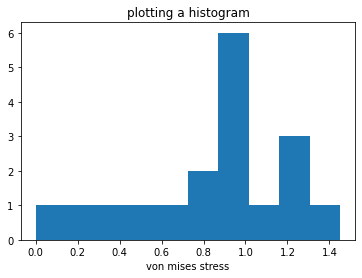

In [21]:
# von mises stress comparison. 

import matplotlib.pyplot as plt

num_bins = 10 
plt.hist(von_mises[3], num_bins)
plt.title("plotting a histogram")
plt.xlabel("von mises stress")
plt.show()



In [22]:
import numpy as np 

i = 0
while i < 1064:
    avg = np.mean(von_mises[i])
    stan = np.std(von_mises[i])
    count = 0 
    for x in von_mises[i]:
        if x < avg - (3*stan):
            print(x, 'is an outlier at element', i, 'at time step', count)
        elif x > avg + (3*stan): 
            print(x, 'is an outlier at element', i, 'at time step', count)
        else: 
            pass
        count = count + 1
    i = i + 1

In [23]:
# Just setting some plotting parameters.
from matplotlib import rcParams

ft = 14
plotParams = {
    'font.family':'serif',
    'font.serif':'Times New Roman',
    'font.size' : ft,
    'axes.labelsize' : ft,
    'legend.fontsize' : ft,
    'xtick.labelsize' : ft, 
    'ytick.labelsize' : ft, 
    'lines.markersize' : 3,
    'lines.linewidth' : 1,
    'axes.linewidth' : 1,
    'lines.antialiased': True,
    'text.usetex': False,
    'figure.figsize': [6,4],
    'legend.frameon': True,
}

rcParams.update(plotParams)

(array([27]),)


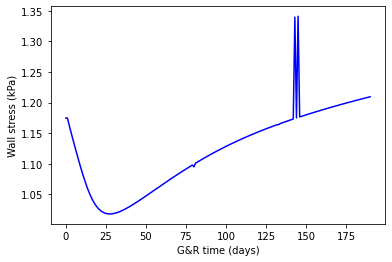

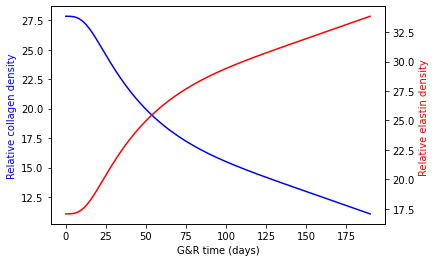

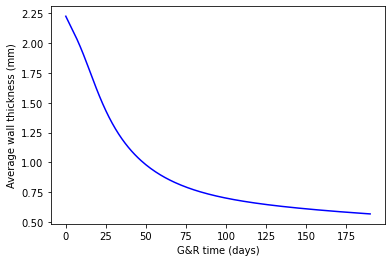

In [36]:
## De-bugging the fea by visualising the trends: 

import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,190, num = 191)

# rememeber to change the save staments first !!!!

von_track1 = np.loadtxt("saved_data/trackers/von1.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element8_von_track.txt", von_track1, delimiter =",")
c_track1 = np.loadtxt("saved_data/trackers/c_density1.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element8_c_track.txt", c_track1, delimiter =",")
e_track1 = np.loadtxt("saved_data/trackers/e_density1.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element8_e_track.txt", e_track1, delimiter =",")
thick_track1 = np.loadtxt("saved_data/trackers/thick_av1.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element8_thick_track.txt", thick_track1, delimiter =",")
production_track1 = np.loadtxt("saved_data/trackers/density_production_track1.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element8_production_track.txt", production_track1, delimiter =",")

print(np.where(von_track1[0:191] == min(von_track1[0:151])))

plt.plot(time, von_track1[0:191], '-b')
plt.ylabel("Wall stress (kPa)")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_stress8.pdf', bbox_inches= "tight")
plt.show()

fig, ax1 = plt.subplots()
plt.xlabel("G&R time (days)")
ax1.plot(time, c_track1[0:191], '-b')
ax1.set_ylabel("Relative collagen density", color = 'blue')
ax2 = ax1.twinx()
ax2.plot(time, e_track1[0:191], '-r')
ax2.set_ylabel("Relative elastin density ", color = 'red')
plt.savefig('Saved_Simulation/collagen&Elastin_density8.pdf', bbox_inches= "tight")
plt.show()


plt.plot(time, thick_track1[0:191], '-b')
plt.ylabel("Average wall thickness (mm)")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_thick8.pdf', bbox_inches= "tight")
plt.show()



(array([0, 1]),)


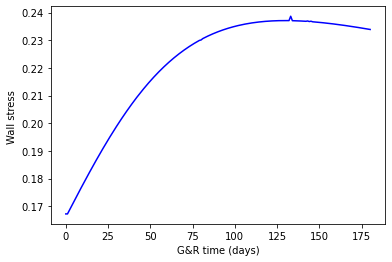

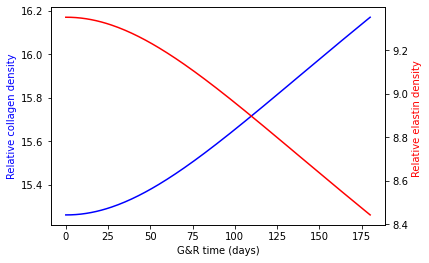

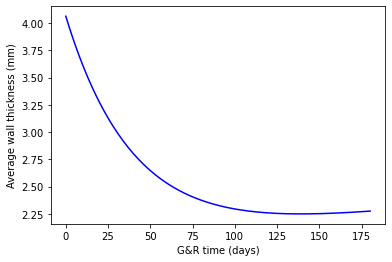

In [34]:
von_track2 = np.loadtxt("saved_data/trackers/von2.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element713_von_track.txt", von_track2, delimiter =",")
c_track2 = np.loadtxt("saved_data/trackers/c_density2.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element713_c_track.txt", c_track2, delimiter =",")
e_track2 = np.loadtxt("saved_data/trackers/e_density2.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element713_e_track.txt", e_track2, delimiter =",")
thick_track2 = np.loadtxt("saved_data/trackers/thick_av2.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element713_thick_track.txt", thick_track2, delimiter =",")
production_track2 = np.loadtxt("saved_data/trackers/density_production_track2.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element713_production_track.txt", production_track2, delimiter =",")

print(np.where(von_track2 == min(von_track2)))

plt.plot(time, von_track2[0:181], '-b')
plt.ylabel("Wall stress ")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_stress713.pdf', bbox_inches= "tight")
plt.show()

fig, ax1 = plt.subplots()
plt.xlabel("G&R time (days)")
ax1.plot(time, c_track2[0:181], '-b')
ax1.set_ylabel("Relative collagen density", color = 'blue')
ax2 = ax1.twinx()
ax2.plot(time, e_track2[0:181], '-r')
ax2.set_ylabel("Relative elastin density ", color = 'red')
plt.savefig('Saved_Simulation/collagen&Elastin_density713.pdf', bbox_inches= "tight")
plt.show()


plt.plot(time, thick_track2[0:181], '-b')
plt.ylabel("Average wall thickness (mm)")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_thick713.pdf', bbox_inches= "tight")
plt.show()

(array([0, 1]),)


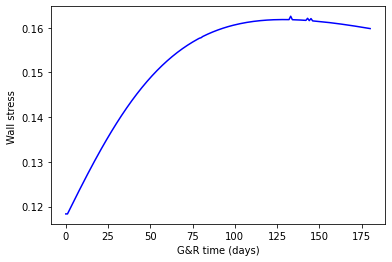

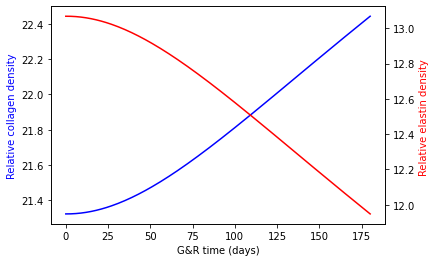

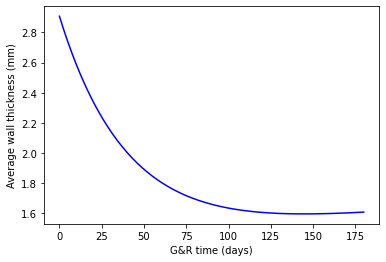

In [35]:
von_track3 = np.loadtxt("saved_data/trackers/von3.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element1_von_track858.txt", von_track3, delimiter =",")
c_track3 = np.loadtxt("saved_data/trackers/c_density3.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element1_c_track858.txt", c_track3, delimiter =",")
e_track3 = np.loadtxt("saved_data/trackers/e_density3.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element1_e_track858.txt", e_track3, delimiter =",")
thick_track3 = np.loadtxt("saved_data/trackers/thick_av3.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element1_thick_track858.txt", thick_track3, delimiter =",")
production_track3 = np.loadtxt("saved_data/trackers/density_production_track3.txt", delimiter = ",")
np.savetxt("Saved_Simulation/element1_production_track858.txt", production_track3, delimiter =",")

print(np.where(von_track3 == min(von_track3)))

plt.plot(time, von_track3[0:181], '-b')
plt.ylabel("Wall stress ")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_stress858.pdf', bbox_inches= "tight")
plt.show()

fig, ax1 = plt.subplots()
plt.xlabel("G&R time (days)")
ax1.plot(time, c_track3[0:181], '-b')
ax1.set_ylabel("Relative collagen density", color = 'blue')
ax2 = ax1.twinx()
ax2.plot(time, e_track3[0:181], '-r')
ax2.set_ylabel("Relative elastin density ", color = 'red')
plt.savefig('Saved_Simulation/collagen&Elastin_density858.pdf', bbox_inches= "tight")
plt.show()


plt.plot(time, thick_track3[0:181], '-b')
plt.ylabel("Average wall thickness (mm)")
plt.xlabel("G&R time (days)")
plt.savefig('Saved_Simulation/wall_thick858.pdf', bbox_inches= "tight")
plt.show()

In [13]:
c = 0.6200000002357596 * (999.9929003391316/0.62)
e = 0.37999999976424037 * (3.255543709422793/0.38)
print(c)
print(e)

999.9929007193864
3.2555437074029885


In [6]:
import numpy as np 

a = np.zeros(1064)
print(a.shape)

b = np.loadtxt("saved_data/homeostatic_stress.txt", delimiter =',')

if all (x == 0 for x in a): 
    print("error")
else: 
    pass

# check there wasn't an error termination on previous step
a = np.loadtxt("saved_data/stress_data/current_von_mises.txt", delimiter = ',')

if all (x == 0 for x in a): 
    print("error")
    print("simulation stopped")
else: 
    print("no error")

(1064,)
error
no error


In [11]:
import numpy as np 
from Read_XPLTfuncs import * 

homeostatic = np.loadtxt("saved_data/homeostatic_stress.txt")

xpltname = './jobs/FEBIO'+ 'tav' + '25' + '.xplt'
nDoms = 1064

#Run GetFeb, using .xplt filename, the number of domains and your to output the data tress using True or False 
feb, _,nStates, _= GetFEB(xpltname,nDoms,False)
Nodes, nElems, nVar, StateTimes, VarNames, VarType = GetMeshInfo(feb)

stress = GetData(feb,'stress',nStates,nVar)
stress = np.array(stress)

all_von_data = []

n = 0
while n < len(stress.T): 
    von_data = []
    i = 0 
    while i < nStates : 
        a = float((stress[i,n]-stress[i,n+1])**2 + (stress[i,n+1]-stress[i,n+2])**2 + (stress[i,n+2]-stress[i,n])**2)
        b = (stress[i,n+3])**2 + (stress[i,n+4])**2 + (stress[i,n+5])**2
        v = (0.5*a) + (float(3)*b)
        von = np.sqrt(v)
        von_data.append(von)
        i = i + 1
    all_von_data.append(von_data) 
    n = n + 6  
von_mises = np.array(all_von_data) 

print("on day 25:", von_mises[7])
print(np.mean(von_mises[7]))


xpltname = './jobs/FEBIO'+ 'tav' + '0' + '.xplt'
nDoms = 1064

#Run GetFeb, using .xplt filename, the number of domains and your to output the data tress using True or False 
feb, _,nStates, _= GetFEB(xpltname,nDoms,False)
Nodes, nElems, nVar, StateTimes, VarNames, VarType = GetMeshInfo(feb)

stress = GetData(feb,'stress',nStates,nVar)
stress = np.array(stress)

all_von_data = []

n = 0
while n < len(stress.T): 
    von_data = []
    i = 0 
    while i < nStates : 
        a = float((stress[i,n]-stress[i,n+1])**2 + (stress[i,n+1]-stress[i,n+2])**2 + (stress[i,n+2]-stress[i,n])**2)
        b = (stress[i,n+3])**2 + (stress[i,n+4])**2 + (stress[i,n+5])**2
        v = (0.5*a) + (float(3)*b)
        von = np.sqrt(v)
        von_data.append(von)
        i = i + 1
    all_von_data.append(von_data) 
    n = n + 6  
von_mises = np.array(all_von_data) 

print("on day 0:", von_mises[7])
print(np.mean(von_mises[7]))

von = []
i = 0 
while i < nDoms: 
    x = np.mean(von_mises[i])
    von.append(x) 
    i = i + 1
von = np.asarray(von)

difference = np.subtract(von, homeostatic)
#for x in difference: 
    #print(x)

on day 25: [0.         0.47267564 0.46977105 0.48883229 0.80382547 0.87627206
 1.34061753 1.47564977 2.02142366 2.17420567 1.44929665 1.18482898
 0.91981288 0.86897437 1.26102132 1.21902924 1.14753315 0.38503949]
1.0310449572925549
on day 0: [0.         0.43225728 0.56829173 0.63654502 1.12975432 1.23570345
 1.84663004 2.05033129 2.61210781 2.65692271 1.4745691  1.14785542
 0.89652842 0.79595015 1.19353292 1.15269287 1.04106062 0.27454548]
1.174737702611553


In [18]:
xpltname = './jobs/FEBIO'+ 'tav' + '400' + '.xplt'
nDoms = 1064

#Run GetFeb, using .xplt filename, the number of domains and your to output the data tress using True or False 
feb, _,nStates, _= GetFEB(xpltname,nDoms,False)
Nodes, nElems, nVar, StateTimes, VarNames, VarType = GetMeshInfo(feb)

stress = GetData(feb,'stress',nStates,nVar)
stress = np.array(stress)

all_von_data = []

n = 0
while n < len(stress.T): 
    von_data = []
    i = 0 
    while i < nStates : 
        a = float((stress[i,n]-stress[i,n+1])**2 + (stress[i,n+1]-stress[i,n+2])**2 + (stress[i,n+2]-stress[i,n])**2)
        b = (stress[i,n+3])**2 + (stress[i,n+4])**2 + (stress[i,n+5])**2
        v = (0.5*a) + (float(3)*b)
        von = np.sqrt(v)
        von_data.append(von)
        i = i + 1
    all_von_data.append(von_data) 
    n = n + 6  
von_mises = np.array(all_von_data) 

von = []
i = 0 
while i < nDoms: 
    x = np.mean(von_mises[i])
    von.append(x) 
    i = i + 1
von = np.asarray(von)

difference = np.subtract(von, homeostatic)

for x in difference: 
    print(x)

0.28576495517252265
0.4374511691455649
0.3682037390698858
0.5074779529063661
0.5798477292682025
0.16852407517874246
0.5865733970502349
0.4412512934408399
0.41407438327245716
0.26101580715208594
0.15232194011071631
0.015876807581145735
0.09882512301339719
0.24200976224435833
0.4594099952439348
0.317052062029907
0.3492484878242448
0.5070784015852237
0.3548089543290118
0.3116944303538758
0.1752948565891015
0.27353803622979567
0.2908422334954307
0.23767679541991282
0.26031556875078044
0.1627447359999813
0.19649446096769374
0.21202081842397502
0.2295862706363262
0.3014391298974508
0.4015249293610583
0.45010653743492457
0.4018187448627655
0.340446134594318
0.2673226628334755
0.1862218222254695
0.16766847544172375
0.15560799051208984
0.14656715801387865
0.14343688967680474
0.13890161204821216
0.2669126723710785
0.06156028525829049
0.04486057791469611
0.07796622316565921
0.06200981074736128
0.0772407712138623
0.053711323390664784
0.06810957847302146
0.06882117910874186
0.08828748185906476
0.07